In [130]:
import pandas as pd

data = pd.read_csv("../new_csv/data_with_agents_split.csv")
data.head()

,GameRulesetName,Id,agent1,agent2,utility_agent1,utility_agent2,Stochastic,HiddenInformation,Match,Asymmetric,...,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt,SolvedEnd,SkillTrace,SkillTraceScore,SkillTraceTrials,SkillTraceErrorSlope,SkillTraceErrorIntercept
0,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
# Investigate the presence of the Random agent

no_randoms = ((data["agent1"] == "'Random'") | (data["agent2"] == "'Random'")).sum()
print(f"{no_randoms} out of the {data.shape[0]} match-ups are with a Random agent")

# Pretty much half of our match-ups involve a Random agent

134053 out of the 266309 match-ups are with a Random agent


In [132]:
# Investigate whether agents can play themselves

agents = data["agent1"].unique()
agents.sort()

for a in agents:
    if ((data["agent1"] == a) & (data["agent2"] == a)).any():
        print("Bingo")
        break

Bingo


In [133]:
# Remove:
# - "Mbenga_Alignment_Game" and "Kriegspiel_Chess" (nothing but NaNs)
# - "Kriegsspiel" (remaining NaNs) (seems like matches were never played, but still recorded; no error file though)
# - Non-two player games

mod_data = data.copy()

f = mod_data["GameRulesetName"].apply(lambda name: name not in ["Mbenga_Alignment_Game", "Kriegspiel_Chess", "Kriegsspiel"])
mod_data = mod_data[f]

mod_data = mod_data[mod_data["TwoPlayer"] == 1]
mod_data = mod_data.drop(columns=["TwoPlayer"])

In [134]:
# We should remove the match-ups in which both agents are the same
# After all, we are not interested in predicting the winner of "a vs a"

no_removed = 0
for a in agents:
    indices = mod_data[(mod_data["agent1"] == a) & (mod_data["agent2"] == a)].index
    mod_data = mod_data.drop(index=indices)
    
    print(f"{a}: {len(indices)} match-ups")
    no_removed += len(indices)

print(f"Total: {no_removed} match-ups")

'MCTS-ProgressiveHistory-0.1-MAST': 60 match-ups
'MCTS-ProgressiveHistory-0.1-NST': 120 match-ups
'MCTS-ProgressiveHistory-0.1-Random0': 40 match-ups
'MCTS-ProgressiveHistory-0.1-Random200': 20 match-ups
'MCTS-ProgressiveHistory-0.1-Random4': 40 match-ups
'MCTS-ProgressiveHistory-0.6-MAST': 60 match-ups
'MCTS-ProgressiveHistory-0.6-NST': 35 match-ups
'MCTS-ProgressiveHistory-0.6-Random0': 20 match-ups
'MCTS-ProgressiveHistory-0.6-Random200': 60 match-ups
'MCTS-ProgressiveHistory-0.6-Random4': 0 match-ups
'MCTS-ProgressiveHistory-1.41421356237-MAST': 40 match-ups
'MCTS-ProgressiveHistory-1.41421356237-NST': 40 match-ups
'MCTS-ProgressiveHistory-1.41421356237-Random0': 0 match-ups
'MCTS-ProgressiveHistory-1.41421356237-Random200': 0 match-ups
'MCTS-ProgressiveHistory-1.41421356237-Random4': 20 match-ups
'MCTS-UCB1-0.1-MAST': 0 match-ups
'MCTS-UCB1-0.1-NST': 60 match-ups
'MCTS-UCB1-0.1-Random0': 18 match-ups
'MCTS-UCB1-0.1-Random200': 60 match-ups
'MCTS-UCB1-0.1-Random4': 58 match-ups
'MC

In [135]:
# Investigate the utility values

mod_data["utility_agent1"].value_counts()

utility_agent1
 1.0    108248
-1.0    101071
 0.0     29091
Name: count, dtype: int64

In [136]:
mod_data[["utility_agent1", "utility_agent2"]].drop_duplicates()

,utility_agent1,utility_agent2
0,1.0,-1.0
11,0.0,0.0
12,-1.0,1.0
266044,-1.0,-1.0


In [137]:
# NOTE: The following code is redundant when only two-player games are taken into account. It seems that we get utility values that are not in {-1, 0, 1} only when a game has more than two players.

# It seems we don't always have a [1, -1] (winner, loser), [-1, 1] (loser, winner) or [0, 0] (draw)
# Let's define the utility of an agent as whether they were better than their opponent
# Then:
# - utility_agent1 == utility_agent2 -> draw [0, 0]
# - utility_agent1 > utility_agent2 -> agent 1 wins; agent 2 loses [1, -1]
# - utility_agent1 < utility_agent2 -> agent 1 loses; agent 2 wins [-1, 1]

def modify_utilities(utilities):
    mod_utilities = utilities.copy()
    
    if utilities.iloc[0] == utilities.iloc[1]:
        mod_utilities.iloc[0] = 0
        mod_utilities.iloc[1] = 0
    elif utilities.iloc[0] > utilities.iloc[1]:
        mod_utilities.iloc[0] = 1
        mod_utilities.iloc[1] = -1
    else:
        mod_utilities.iloc[0] = -1
        mod_utilities.iloc[1] = 1
    
    return mod_utilities

mod_data[["utility_agent1", "utility_agent2"]] = mod_data[["utility_agent1", "utility_agent2"]].apply(lambda utilities: modify_utilities(utilities), axis=1)

In [138]:
# Generate data on match-ups between agents

no_agents = len(agents)
matchup_data = {
    "Agent 1": [],
    "Agent 2": [],
    "No matches": [],
    "No draws": [],
    "No wins by 1": [],
    "No wins by 2": [],
    "No games": []
}

for i in range(no_agents):
    for j in range(no_agents):
        if i == j:
            continue
        
        matchup_data["Agent 1"].append(agents[i])
        matchup_data["Agent 2"].append(agents[j])
        
        matches = mod_data[(mod_data["agent1"] == agents[i]) & (mod_data["agent2"] == agents[j])]
        
        no_matches = matches.shape[0]
        matchup_data["No matches"].append(no_matches)
        
        if no_matches == 0:
            for col in ["No draws", "No wins by 1", "No wins by 2", "No games"]:
                matchup_data[col].append(0)
            continue
        
        no_draws = (matches["utility_agent1"] == matches["utility_agent2"]).sum()
        matchup_data["No draws"].append(no_draws)

        no_wins_by_1 = (matches["utility_agent1"] > matches["utility_agent2"]).sum()
        matchup_data["No wins by 1"].append(no_wins_by_1)

        no_wins_by_2 = (matches["utility_agent2"] > matches["utility_agent1"]).sum()
        matchup_data["No wins by 2"].append(no_wins_by_2)
        
        no_games = matches["Id"].nunique()
        matchup_data["No games"].append(no_games)

matchup_data = pd.DataFrame.from_dict(matchup_data)
matchup_data

,Agent 1,Agent 2,No matches,No draws,No wins by 1,No wins by 2,No games
0,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',40,0,24,16,4
1,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random0',16,6,0,10,2
2,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random200',50,0,16,34,5
3,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random4',47,24,12,11,5
4,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.6-MAST',50,10,7,33,5
...,...,...,...,...,...,...,...
3655,'Random','MCTS-UCB1Tuned-1.41421356237-MAST',900,77,36,787,89
3656,'Random','MCTS-UCB1Tuned-1.41421356237-NST',1110,85,60,965,109
3657,'Random','MCTS-UCB1Tuned-1.41421356237-Random0',990,105,107,778,96
3658,'Random','MCTS-UCB1Tuned-1.41421356237-Random200',1100,68,41,991,110


In [139]:
# Investigate generated data

matchless = matchup_data[matchup_data["No matches"] == 0]
matchless

,Agent 1,Agent 2,No matches,No draws,No wins by 1,No wins by 2,No games
24,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-UCB1-1.41421356237-MAST',0,0,0,0,0
103,'MCTS-ProgressiveHistory-0.1-NST','MCTS-UCB1GRAVE-1.41421356237-Random4',0,0,0,0,0
132,'MCTS-ProgressiveHistory-0.1-Random0','MCTS-ProgressiveHistory-1.41421356237-Random200',0,0,0,0,0
251,'MCTS-ProgressiveHistory-0.1-Random4','MCTS-ProgressiveHistory-1.41421356237-Random0',0,0,0,0,0
254,'MCTS-ProgressiveHistory-0.1-Random4','MCTS-UCB1-0.1-MAST',0,0,0,0,0
...,...,...,...,...,...,...,...
3357,'MCTS-UCB1Tuned-1.41421356237-MAST','MCTS-UCB1Tuned-1.41421356237-Random200',0,0,0,0,0
3535,'MCTS-UCB1Tuned-1.41421356237-Random200','MCTS-UCB1Tuned-1.41421356237-MAST',0,0,0,0,0
3559,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1-0.1-Random4',0,0,0,0,0
3563,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1-0.6-Random200',0,0,0,0,0


In [140]:
# It seems that not all match-ups are covered by the data -> let's remove them

def get_indices(matchup):
    m_idx = matchup_data[(matchup_data["Agent 1"] == matchup.iloc[0]) & (matchup_data["Agent 2"] == matchup.iloc[1])].index[0]
    if m_idx in indices:
        return 
    indices.append(m_idx)
    
    # Let's ensure the reverse of this match-up also gets removed (even if it is present in the data!)
    r_idx = matchup_data[(matchup_data["Agent 1"] == matchup.iloc[1]) & (matchup_data["Agent 2"] == matchup.iloc[0])].index[0]
    indices.append(r_idx)

indices = []
matchless[["Agent 1", "Agent 2"]].apply(lambda matchup: get_indices(matchup), axis=1)
matchup_data = matchup_data.drop(index=indices)

In [141]:
# Generate win percentage columns
matchup_data["Win percentage of 1"] = matchup_data["No wins by 1"] / matchup_data["No matches"] * 100
matchup_data["Win percentage of 2"] = matchup_data["No wins by 2"] / matchup_data["No matches"] * 100

# Remove match-ups involving a Random agent
matchup_data = matchup_data[(matchup_data["Agent 1"] != "'Random'") & (matchup_data["Agent 2"] != "'Random'")]

matchup_data

,Agent 1,Agent 2,No matches,No draws,No wins by 1,No wins by 2,No games,Win percentage of 1,Win percentage of 2
0,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',40,0,24,16,4,60.000000,40.000000
1,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random0',16,6,0,10,2,0.000000,62.500000
2,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random200',50,0,16,34,5,32.000000,68.000000
3,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random4',47,24,12,11,5,25.531915,23.404255
4,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.6-MAST',50,10,7,33,5,14.000000,66.000000
...,...,...,...,...,...,...,...,...,...
3594,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1Tuned-0.6-Random4',30,1,15,14,3,50.000000,46.666667
3595,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1Tuned-1.41421356237-MAST',20,0,8,12,2,40.000000,60.000000
3596,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1Tuned-1.41421356237-NST',50,0,5,45,5,10.000000,90.000000
3597,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1Tuned-1.41421356237-Random0',26,11,9,6,3,34.615385,23.076923


In [142]:
# Generate descriptives on match-ups

matchup_data.describe()

,No matches,No draws,No wins by 1,No wins by 2,No games,Win percentage of 1,Win percentage of 2
count,3430.00000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000
mean,34.48688,5.373178,15.404373,13.709329,3.519534,44.589951,39.293524
std,17.26939,6.055068,11.352001,10.855116,1.755896,25.930476,25.426658
min,6.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,20.00000,0.000000,7.000000,6.000000,2.000000,25.862069,20.000000
50%,30.00000,4.000000,13.000000,11.000000,3.000000,43.333333,38.000000
75%,47.00000,9.000000,22.000000,20.000000,5.000000,62.500000,55.854072
max,100.00000,38.000000,78.000000,70.000000,10.000000,100.000000,100.000000


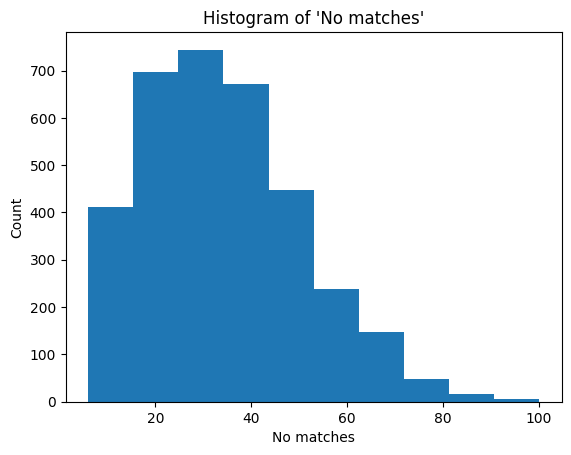

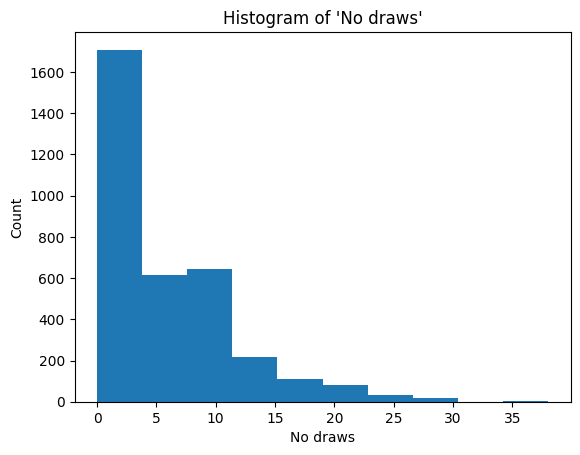

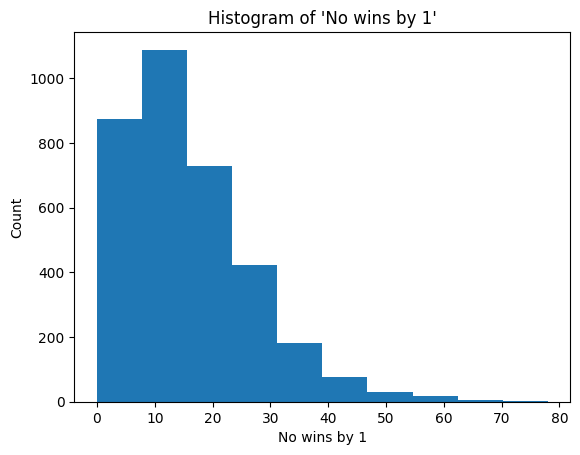

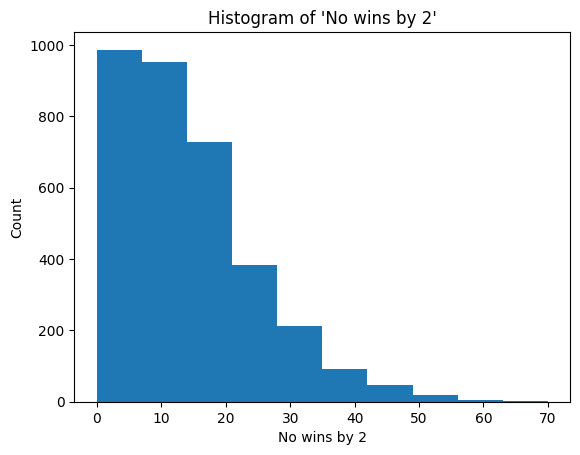

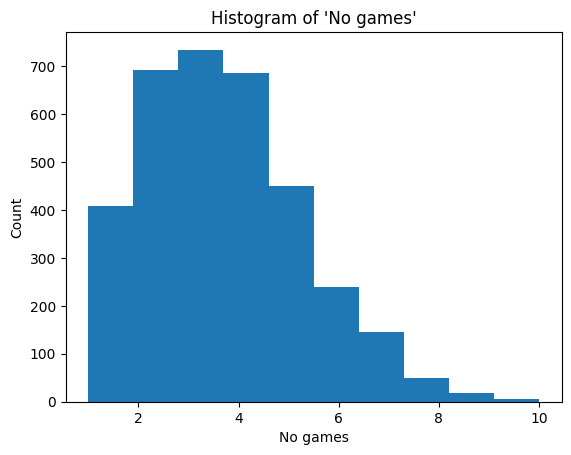

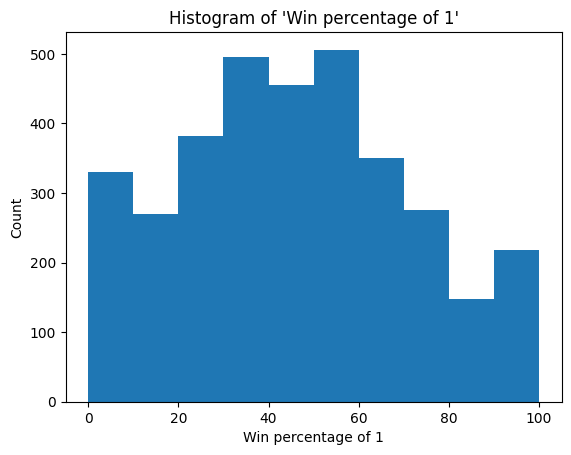

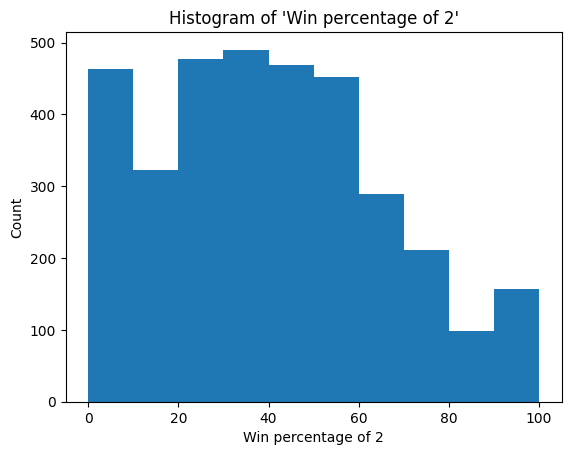

In [143]:
# Generate histograms on match-ups

from matplotlib import pyplot as plt

def generate_histogram(column):
    plt.hist(matchup_data[column], bins=10)
    plt.title(f"Histogram of '{column}'")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

for col in matchup_data.columns:
    if col in ["Agent 1", "Agent 2"]:
        continue
    
    generate_histogram(col)

In [144]:
# Let's do some filtering on our matches data

def get_legal_matchups():
    matchups = []
    matchup_data[["Agent 1", "Agent 2"]].apply(lambda m: matchups.append((m.iloc[0], m.iloc[1])), axis=1)
    return matchups

legal_matchups = get_legal_matchups()
f = mod_data[["agent1", "agent2"]].apply(lambda m: (m.iloc[0], m.iloc[1]) in legal_matchups, axis=1)
mod_data = mod_data[f]

In [145]:
# Remove variables with one unique value

one_unique_vars = []
for col in mod_data.columns[6:]:
    if mod_data[col].nunique() == 1:
        one_unique_vars.append(col)
mod_data = mod_data.drop(columns=one_unique_vars)

In [146]:
sin_vars = []
bin_vars = []
mul_vars = []

for col in mod_data.columns[6:]:
    u = mod_data[col].unique()
    
    if u.shape[0] == 1:
        sin_vars.append(col)
    elif u.shape[0] == 2:
        bin_vars.append(col)
    else:
        mul_vars.append(col)

In [147]:
for col in mul_vars:
    u = mod_data[col].unique()
    u.sort()
    
    s = ""
    for v in u:
        s += f"{v} | "
    
    print(f"{s}{col}\n")

1.0 | 4.0 | 5.0 | 6.0 | 7.0 | 8.0 | 9.0 | 10.0 | 11.0 | 12.0 | 13.0 | 14.0 | 15.0 | 16.0 | 17.0 | 18.0 | 19.0 | 20.0 | 21.0 | 23.0 | 24.0 | 25.0 | 26.0 | 27.0 | 28.0 | 29.0 | 30.0 | 31.0 | 32.0 | 33.0 | 34.0 | 35.0 | 36.0 | 37.0 | 38.0 | 39.0 | 40.0 | 41.0 | 42.0 | 43.0 | 45.0 | 46.0 | 48.0 | 49.0 | 50.0 | 52.0 | 53.0 | 54.0 | 55.0 | 56.0 | 57.0 | 59.0 | 60.0 | 61.0 | 63.0 | 64.0 | 65.0 | 66.0 | 68.0 | 70.0 | 71.0 | 72.0 | 73.0 | 75.0 | 77.0 | 79.0 | 80.0 | 81.0 | 84.0 | 85.0 | 87.0 | 88.0 | 90.0 | 91.0 | 92.0 | 93.0 | 96.0 | 97.0 | 100.0 | 104.0 | 109.0 | 110.0 | 112.0 | 113.0 | 114.0 | 119.0 | 120.0 | 121.0 | 123.0 | 124.0 | 126.0 | 127.0 | 128.0 | 132.0 | 133.0 | 134.0 | 140.0 | 144.0 | 145.0 | 147.0 | 151.0 | 152.0 | 157.0 | 160.0 | 162.0 | 169.0 | 176.0 | 181.0 | 192.0 | 196.0 | 200.0 | 204.0 | 208.0 | 225.0 | 249.0 | 256.0 | 261.0 | 289.0 | 294.0 | 306.0 | 315.0 | 361.0 | 545.0 | 625.0 | 1261.0 | 1681.0 | NumPlayableSitesOnBoard

1.0 | 2.0 | 3.0 | 4.0 | 5.0 | 6.0 | 7.0 | 8.0 | 9.

In [148]:
differences = {}

for matchup in legal_matchups:
    A = matchup[0]
    B = matchup[1]
    
    matches_AB = mod_data[(mod_data["agent1"] == A) & (mod_data["agent2"] == B)]
    matches_BA = mod_data[(mod_data["agent1"] == B) & (mod_data["agent2"] == A)]
    
    if (matches_AB["GameRulesetName"].unique() != matches_BA["GameRulesetName"].unique()).any():
        print(matchup)
    
    diff = abs(matches_AB.shape[0] - matches_BA.shape[0])
    if diff not in differences:
        differences[diff] = 0
    differences[diff] += 1

print(differences)

{0: 3000, 1: 416, 2: 14}


In [149]:
# ML brainstorm:
# - First idea:
#       * When tasked with answering the question "Which of the agents A and B performs better?", we restrict ourselves to the portion of the data that describes matches between A and B.
#       * We need to compress the matches from the same game into one instance:
#           > Features: values of concepts (ruleset)
#           > Label: A / B / Draw
#       * We can start easy with a Decision Tree, which does feature selection for us.
#       * Potential problems:
#           > Not enough instances per match-up
#           > Imbalanced dataset may yield a poor Decision Tree classifier
# - Second idea:
#       * Idem, but with the question "Which of the expansion strategies/exploration constants/play-out strategies A and B performs better?"
#       * Potential problems:
#           > Dependencies between components need to be captured

# Dismantle agents into their components

def dismantle_agents(x):
    agent1_split = x.iloc[0].replace("'", "").split("-")[1:]
    agent2_split = x.iloc[1].replace("'", "").split("-")[1:]

    components["expansion_agent1"].append(agent1_split[0])
    components["exploration_agent1"].append(agent1_split[1])
    components["playout_agent1"].append(agent1_split[2])

    components["expansion_agent2"].append(agent2_split[0])
    components["exploration_agent2"].append(agent2_split[1])
    components["playout_agent2"].append(agent2_split[2])

components = {
    "expansion_agent1": [],
    "exploration_agent1": [],
    "playout_agent1": [],
    
    "expansion_agent2": [],
    "exploration_agent2": [],
    "playout_agent2": []
}
mod_data[["agent1", "agent2"]].apply(lambda x: dismantle_agents(x), axis=1)

for col in components:
    mod_data[col] = components[col]

mod_data = mod_data[mod_data.columns[:2].tolist() + mod_data.columns[-6:].tolist() + mod_data.columns[4:-6].tolist()]

mod_data = mod_data.astype({"exploration_agent1": "float64", "exploration_agent2": "float64"})

mod_data

,GameRulesetName,Id,expansion_agent1,exploration_agent1,playout_agent1,expansion_agent2,exploration_agent2,playout_agent2,utility_agent1,utility_agent2,...,DiceD2,DiceD4,DiceD6,PlayersWithDirections,DurationTurnsStdDev,DurationTurnsNotTimeouts,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt
60,Adugo,37,UCB1,0.6,Random4,UCB1GRAVE,0.6,Random4,0.0,0.0,...,0.0,0.0,0.0,0.0,109.35,385.3,7.5,0.0,7.5,0.0
61,Adugo,37,UCB1,0.6,Random4,UCB1GRAVE,0.6,Random4,0.0,0.0,...,0.0,0.0,0.0,0.0,109.35,385.3,7.5,0.0,7.5,0.0
62,Adugo,37,UCB1,0.6,Random4,UCB1GRAVE,0.6,Random4,0.0,0.0,...,0.0,0.0,0.0,0.0,109.35,385.3,7.5,0.0,7.5,0.0
63,Adugo,37,UCB1,0.6,Random4,UCB1GRAVE,0.6,Random4,0.0,0.0,...,0.0,0.0,0.0,0.0,109.35,385.3,7.5,0.0,7.5,0.0
64,Adugo,37,UCB1,0.6,Random4,UCB1GRAVE,0.6,Random4,0.0,0.0,...,0.0,0.0,0.0,0.0,109.35,385.3,7.5,0.0,7.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266264,Shogi_Puzzle,456,UCB1,0.6,Random4,UCB1,0.6,MAST,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.00,1.0,1.0,0.5,1.5,0.0
266265,Shogi_Puzzle,456,UCB1,0.6,Random4,UCB1,0.6,MAST,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.00,1.0,1.0,0.5,1.5,0.0
266266,Shogi_Puzzle,456,UCB1,0.6,Random4,UCB1,0.6,MAST,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.00,1.0,1.0,0.5,1.5,0.0
266267,Shogi_Puzzle,456,UCB1,0.6,Random4,UCB1,0.6,MAST,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.00,1.0,1.0,0.5,1.5,0.0


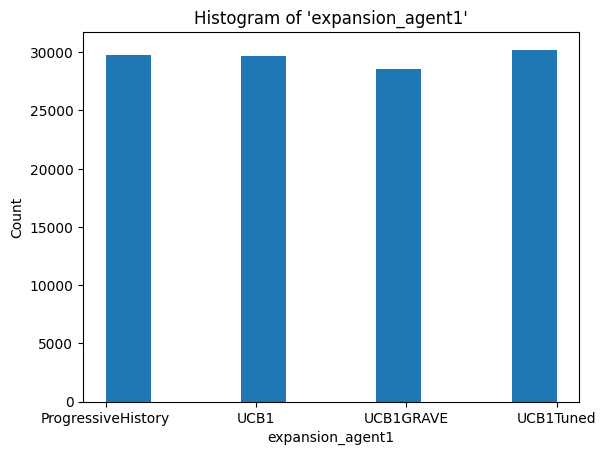

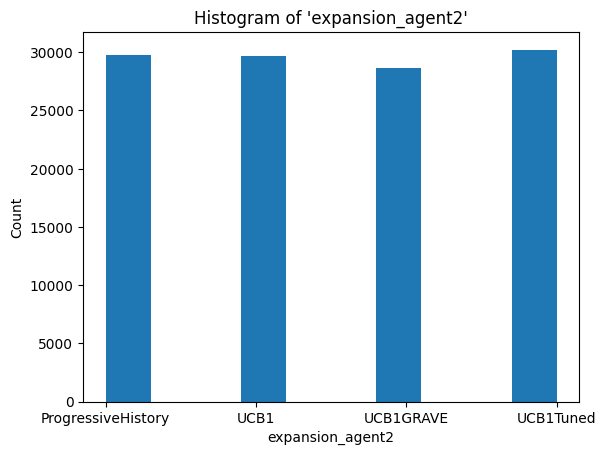

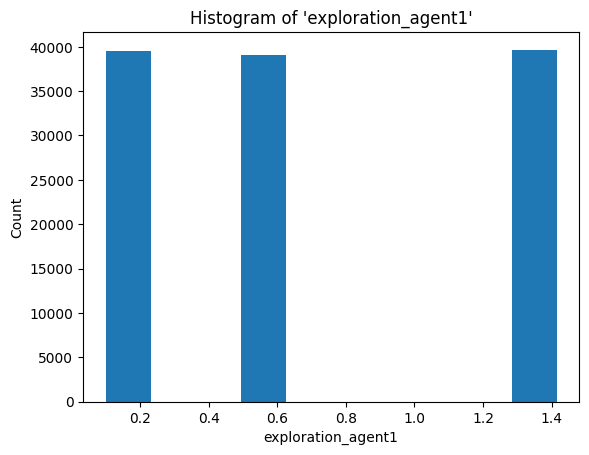

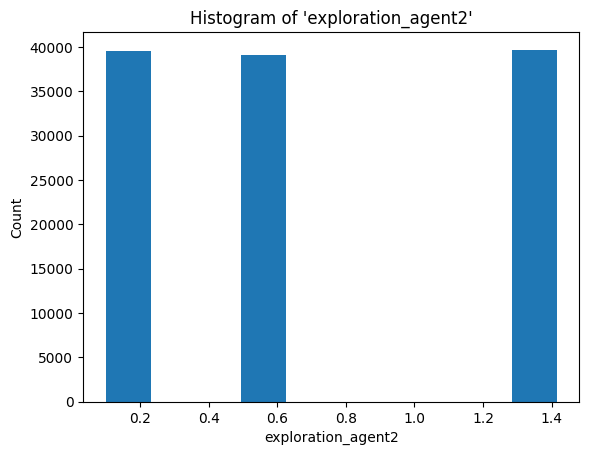

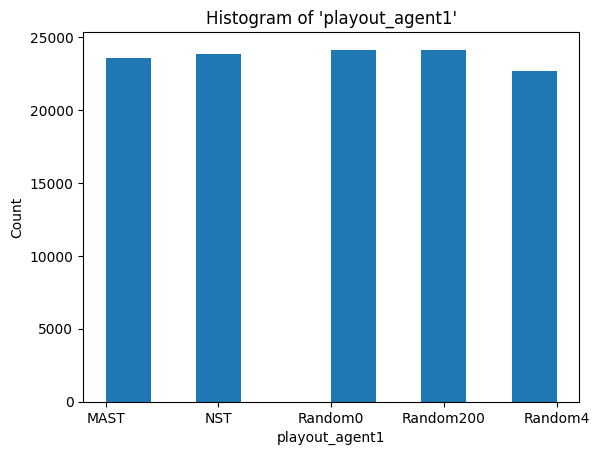

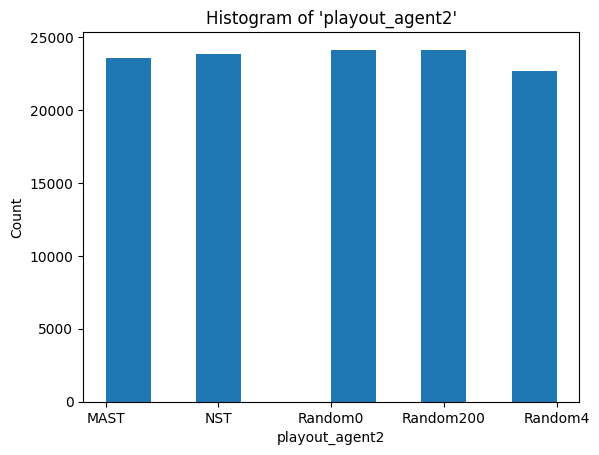

In [150]:
for col in ["expansion_agent1", "expansion_agent2", "exploration_agent1", "exploration_agent2", "playout_agent1", "playout_agent2"]:
    plt.hist(mod_data[col].sort_values())
    plt.title(f"Histogram of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [151]:
# Let's focus on the question "Which of the exploration constants .1 and .6 performs better?"

sub_data = mod_data[((mod_data["exploration_agent1"] == .1) & (mod_data["exploration_agent2"] == .6)) | ((mod_data["exploration_agent1"] == .6) & (mod_data["exploration_agent2"] == .1))]
sub_data

,GameRulesetName,Id,expansion_agent1,exploration_agent1,playout_agent1,expansion_agent2,exploration_agent2,playout_agent2,utility_agent1,utility_agent2,...,DiceD2,DiceD4,DiceD6,PlayersWithDirections,DurationTurnsStdDev,DurationTurnsNotTimeouts,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt
246,Asalto,1368,UCB1Tuned,0.1,Random4,UCB1Tuned,0.6,NST,1.0,-1.0,...,0.0,0.0,0.0,0.0,11.05,17.7,13.0,0.0,13.0,0.0
247,Asalto,1368,UCB1Tuned,0.1,Random4,UCB1Tuned,0.6,NST,1.0,-1.0,...,0.0,0.0,0.0,0.0,11.05,17.7,13.0,0.0,13.0,0.0
248,Asalto,1368,UCB1Tuned,0.1,Random4,UCB1Tuned,0.6,NST,1.0,-1.0,...,0.0,0.0,0.0,0.0,11.05,17.7,13.0,0.0,13.0,0.0
249,Asalto,1368,UCB1Tuned,0.1,Random4,UCB1Tuned,0.6,NST,1.0,-1.0,...,0.0,0.0,0.0,0.0,11.05,17.7,13.0,0.0,13.0,0.0
250,Asalto,1368,UCB1Tuned,0.1,Random4,UCB1Tuned,0.6,NST,1.0,-1.0,...,0.0,0.0,0.0,0.0,11.05,17.7,13.0,0.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265939,Chess_Puzzle,455,UCB1,0.1,Random0,UCB1GRAVE,0.6,Random0,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.00,1.0,1.5,0.0,1.5,1.0
265940,Chess_Puzzle,455,UCB1,0.1,Random0,UCB1GRAVE,0.6,Random0,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.00,1.0,1.5,0.0,1.5,1.0
265941,Chess_Puzzle,455,UCB1,0.1,Random0,UCB1GRAVE,0.6,Random0,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.00,1.0,1.5,0.0,1.5,1.0
265942,Chess_Puzzle,455,UCB1,0.1,Random0,UCB1GRAVE,0.6,Random0,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.00,1.0,1.5,0.0,1.5,1.0


In [152]:
sub_data["exploration_agent1"].value_counts()

exploration_agent1
0.6    13448
0.1    13446
Name: count, dtype: int64

In [153]:
sub_data["exploration_agent2"].value_counts()

exploration_agent2
0.1    13448
0.6    13446
Name: count, dtype: int64

In [154]:
sub_data[["exploration_agent1", "exploration_agent2"]].value_counts()

exploration_agent1  exploration_agent2
0.6                 0.1                   13448
0.1                 0.6                   13446
Name: count, dtype: int64

In [242]:
# Instance format: ruleset | label -> concept values | {.1, .6, Draw}

def update_counters(c, match):
    if match.iloc[0] == 1:
        c[match.iloc[1]] += 1
        return 
    
    c[match.iloc[2]] += 1

games = sub_data["GameRulesetName"].unique()
games.sort()

ml_data = {}
for game in games:
    counters = {
        .1: 0,
        .6: 0
    }

    game_data = sub_data[sub_data["GameRulesetName"] == game]
    game_data[["utility_agent1", "exploration_agent1", "exploration_agent2"]].apply(lambda match: update_counters(counters, match), axis=1)
    
    if counters[.1] == counters[.6]:
        label = "Draw"
    elif counters[.1] > counters[.6]:
        label = ".1"
    else:
        label = ".6"
    
    concept_values = game_data.iloc[0][10:].values.tolist()
    instance = concept_values + [label]
    
    ml_data[game] = instance

ml_data = pd.DataFrame.from_dict(ml_data, orient="index", columns=[sub_data.columns[10:].tolist() + ["Label"]])
ml_data

,Stochastic,HiddenInformation,Asymmetric,AsymmetricForces,AsymmetricPiecesType,Shape,SquareShape,HexShape,TriangleShape,DiamondShape,...,DiceD4,DiceD6,PlayersWithDirections,DurationTurnsStdDev,DurationTurnsNotTimeouts,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt,Label
00Y,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.64,23.88,0.0,0.0,0.0,0.0,.1
3D_Tic-Tac-Toe,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.65,13.92,3.0,0.0,3.0,0.0,.6
4_Squared,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,242.23,76.20,0.0,0.0,0.0,0.0,.6
58_HolesCarter_Crossover_1_D6_Suggested,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,15.79,100.09,0.0,0.0,0.0,0.0,.1
58_HolesCarter_Crossover_1_Suggested,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,17.30,149.51,0.0,0.0,0.0,0.0,.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yote,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,23.60,82.04,0.0,12.0,12.0,0.0,.1
Yovodji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,22.26,54.59,24.0,0.0,24.0,0.0,.6
Yucebao,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,620.79,1411.68,26.0,0.0,26.0,1.0,Draw
Zuz_Mel_5x5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,125.71,309.33,12.0,0.0,12.0,0.0,.6


In [243]:
ml_data["Label"].value_counts()

(Label,)
.6          362
.1          317
Draw        187
Name: count, dtype: int64

In [280]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = ml_data[ml_data.columns[:-1]]
y = ml_data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

In [281]:
model = DecisionTreeClassifier(
    min_samples_leaf=2,
    min_impurity_decrease=.01,
    class_weight="balanced"
).fit(X_train, y_train)

In [282]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          .1       0.60      0.03      0.06        95
          .6       0.49      0.76      0.60       109
        Draw       0.45      0.70      0.55        56

    accuracy                           0.48       260
   macro avg       0.51      0.50      0.40       260
weighted avg       0.52      0.48      0.39       260


In [273]:
X_train

,Stochastic,HiddenInformation,Asymmetric,AsymmetricForces,AsymmetricPiecesType,Shape,SquareShape,HexShape,TriangleShape,DiamondShape,...,DiceD2,DiceD4,DiceD6,PlayersWithDirections,DurationTurnsStdDev,DurationTurnsNotTimeouts,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt
Residuel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.50,35.89,0.0,0.0,0.0,0.0
Dice_Chess,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,110.52,152.07,16.0,0.5,16.5,1.0
Ako_OkweUmuahia_Observed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31.62,119.17,50.0,0.0,50.0,0.0
Les_PendusFive_in_a_Row_Described,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,883.18,1012.82,0.0,5.0,5.0,0.0
Seireigi,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,567.71,617.31,20.0,0.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rimau-Rimau_One_Tiger,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,178.52,508.00,4.5,8.0,12.5,0.0
Schachzabel,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,833.38,99.86,16.0,0.0,16.0,0.0
Crand,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,779.23,1139.04,40.0,0.0,40.0,0.0
AchiMurray_Described,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,134.13,169.76,0.0,6.0,6.0,0.0


In [286]:
X_train.dtypes

Stochastic                          float64
HiddenInformation                   float64
Asymmetric                          float64
AsymmetricForces                    float64
AsymmetricPiecesType                float64
                                     ...   
DurationTurnsNotTimeouts            float64
NumStartComponentsBoardPerPlayer    float64
NumStartComponentsHandPerPlayer     float64
NumStartComponentsPerPlayer         float64
IsPieceAt                           float64
Length: 432, dtype: object

In [287]:
model.feature_importances_

array([0.        , 0.        , 0.        , 0.55805845, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     